# TODO: Clean up, modularize and beautify! 

In [ ]:
import numpy as np
import os, sys, librosa
from librosa import display
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit
from IPython.display import Audio 
import IPython

import cdpam

from scipy.stats import pearsonr, spearmanr

import scipy.spatial as sp

import torch
import torch.nn as nn
import torch.fft
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

import noisereduce as nr

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats
import collections as c

from tifresi.utils import load_signal
from tifresi.utils import preprocess_signal
from tifresi.stft import GaussTF, GaussTruncTF
from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram

from torch.nn.modules.module import _addindent

import copy
import os
import math

import soundfile as sf
from matplotlib.pyplot import figure
import pickle

from sklearn.preprocessing import MinMaxScaler
import glob

import sys
sys.path.insert(0, '../')
import dnnlib
from utils import util, training_utils, losses, masking, gmloss
from networks import stylegan_encoder

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from scipy.signal import freqz,butter, lfilter

%load_ext autoreload
%autoreload 2

In [28]:
network_pkl = '/home/purnima/appdir/Github/StyleGANs/stylegan2-ada-pytorch/training-runs/00044-water-data-split-auto1-noaug/network-snapshot-001400.pkl'

sample_rate = 16000
stft_channels = 512 #510
n_frames = 256
hop_size = 128
sample_rate = 16000
        
device = torch.device('cuda')
with open(network_pkl, 'rb') as pklfile:
    network = pickle.load(pklfile)
    G = network['G'].to(device).eval()


    
    
encoder_pt = '../checkpoints/sgan_encoder_water_resnet-34_RGBM-withthresholding/netE_epoch_best.pth'
netE = stylegan_encoder.load_stylegan_encoder(domain=None, nz=G.z_dim,
                                                   outdim=128,
                                                   use_RGBM=True,#opt.masked,
                                                   use_VAE=False,#opt.vae_like,
                                                   resnet_depth=34,
                                                   ckpt_path=encoder_pt)
netE = netE.to(device).eval()


Using halfsize?: False
Input channels: 2


In [29]:
def applyFBFadeFilter(forward_fadetime,backward_fadetime,signal,fs,expo=1):
    forward_num_fad_samp = int(forward_fadetime*fs) 
    backward_num_fad_samp = int(backward_fadetime*fs) 
    signal_length = len(signal) 
    fadefilter = np.ones(signal_length)
    if forward_num_fad_samp>0:
        fadefilter[0:forward_num_fad_samp]=np.linspace(0,1,forward_num_fad_samp)**expo
    if backward_num_fad_samp>0:
        fadefilter[signal_length-backward_num_fad_samp:signal_length]=np.linspace(1,0,backward_num_fad_samp)**expo
    return fadefilter*signal

def pghi_stft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)
    Y = stft_system.spectrogram(x)
    log_Y= log_spectrogram(Y)
    return np.expand_dims(log_Y,axis=0)

def zeropad(signal, audio_length):
    if len(signal) < audio_length:
        return np.append(
            signal, 
            np.zeros(audio_length - len(signal))
        )
    else:
        signal = signal[0:audio_length]
        return signal

def pghi_istft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)

    x = np.squeeze(x,axis=0)
    new_Y = inv_log_spectrogram(x)
    new_y = stft_system.invert_spectrogram(new_Y)
    return new_y

def renormalize(n, range1, range2):
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    return (delta2 * (n - range1[0]) / delta1) + range2[0]

def read_and_plot(f, title=None):
    y, sr = librosa.load(f, sr=sample_rate)
    plot(y, title)

def plot(y, title=None):
    IPython.display.display(IPython.display.Audio(y, rate=sample_rate))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    y_pghi = y
    y_pghi = preprocess_signal(y_pghi)
    y_pghi = zeropad(y_pghi, n_frames * hop_size )
    y_pghi = pghi_stft(y_pghi)
    
    a=librosa.display.specshow(y_pghi[0],x_axis='time', y_axis='linear', ax=ax[0], sr=sample_rate, hop_length=hop_size)
    ax[0].set_title(title)
    
    ax[1].plot(y)
    
def plot_multi(y1, y2, title1=None, title2=None):
    IPython.display.display(IPython.display.Audio(y1, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(y2, rate=sample_rate))
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    y_pghi = y1
    y_pghi = preprocess_signal(y_pghi)
    y_pghi = zeropad(y_pghi, n_frames * hop_size )
    y_pghi = pghi_stft(y_pghi)
    
    a=librosa.display.specshow(y_pghi[0],x_axis='time', y_axis='linear', ax=ax[0], sr=sample_rate, hop_length=hop_size)
    ax[0].set_title(title1)
    
    y_pghi = y2
    y_pghi = preprocess_signal(y_pghi)
    y_pghi = zeropad(y_pghi, n_frames * hop_size )
    y_pghi = pghi_stft(y_pghi)
    
    a=librosa.display.specshow(y_pghi[0],x_axis='time', y_axis='linear', ax=ax[1], sr=sample_rate, hop_length=hop_size)
    ax[1].set_title(title2)
    


In [30]:
def butter_bandpass(lowcut, highcut, fs, order=5,btype='bandpass'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    return b, a

def butter_lowhighpass(cut, fs, order=5, btype='lowpass'):
    nyq = 0.5 * fs
    cut = cut / nyq
    b, a = butter(order, cut, btype=btype)
    return b, a

def butter_bandpass_filter(data, highcut, fs,lowcut=None,  order=5, btype='bandpass'):
    if btype=='bandpass':
        b, a = butter_bandpass(lowcut, highcut, fs, order=order, btype=btype)
    else:
        b, a = butter_lowhighpass(highcut, fs, order=order, btype=btype)
    y = lfilter(b, a, data)
    return y

def gaver_impact_solidbar_single(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000):
    t_ = np.linspace(0,impulse_time,int(impulse_time*samplerate))
    
    omega_1 = 240 #In Hz. Frequency is inversely proportional to size
    if size == 'small':
        omega_1 = 660
        
    D = 0.001
    if metal_or_plastic == 'plastic':
        D = 0.5
    
    h=[h_ for h_ in np.arange(-0.005, 0.005, (0.005+0.005)/num_partials)][::-1]
    
    gn=np.zeros(int(impulse_time*samplerate))
    for i in range(num_partials):
        omega_n_radians = omega_1*((2*i + 1)**2)/9
        
        phi = initial_amplitude + h[i]*(omega_n_radians - (2*np.pi*omega_1))
        
        delta_n = omega_n_radians * D
        g = phi * np.exp(-1*delta_n*t_) * np.cos(omega_n_radians * t_)
        gn = gn + g
    return gn


def gaver_impact_plate_single(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000):
    t_ = np.linspace(0,impulse_time,int(impulse_time*samplerate))
    
    omega_1 = 60 #In Hz. Frequency is inversely proportional to size
    if size == 'small':
        omega_1 = 250
        
    D = 0.001
    if metal_or_plastic == 'plastic':
        D = 0.3
    
    h=[h_ for h_ in np.arange(-0.005, 0.005, (0.005+0.005)/num_partials)][::-1]
    
    gn=np.zeros(int(impulse_time*samplerate))
    for i in range(num_partials):
        omega_n = omega_1 + i*omega_1 + np.random.randint(50)
        omega_n_radians = 2 * np.pi * omega_n
        
        phi = initial_amplitude + h[i]*(omega_n_radians - (2*np.pi*omega_1))
        
        delta_n = omega_n_radians * D
        g = phi * np.exp(-1*delta_n*t_) * np.cos(omega_n_radians * t_)
        gn = gn + g
    return gn
    
def gaver_impact_plate(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000, total_time=0, locs=None):
    single_hit = gaver_impact_plate_single(initial_amplitude, impulse_time, num_partials, size, metal_or_plastic, samplerate)
    gn=np.zeros(int(total_time*samplerate))
    for loc in locs:
        start_loc = int(loc*sample_rate)
        end_loc = start_loc+len(single_hit)
        single_hit_ = single_hit

        if end_loc > len(gn):
            end_loc = len(gn)
            single_hit_ = single_hit_[0:end_loc-start_loc]

        gn[start_loc:end_loc] = applyFBFadeFilter(forward_fadetime=0.2,backward_fadetime=0,signal=single_hit_,fs=sample_rate)

    return gn/np.max(gn)

def gaver_impact_solidbar(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000, total_time=0, locs=None):
    single_hit = gaver_impact_solidbar_single(initial_amplitude, impulse_time, num_partials, size, metal_or_plastic, samplerate)
    gn=np.zeros(int(total_time*samplerate))
    for loc in locs:
        start_loc = int(loc*sample_rate)
        end_loc = start_loc+len(single_hit)
        single_hit_ = single_hit

        if end_loc > len(gn):
            end_loc = len(gn)
            single_hit_ = single_hit_[0:end_loc-start_loc]

        gn[start_loc:end_loc] = applyFBFadeFilter(forward_fadetime=0.05,backward_fadetime=0,signal=single_hit_,fs=sample_rate)

    return gn/np.max(gn)

In [31]:
def encode_and_reconstruct(audio):
    audio_pghi = preprocess_signal(audio)
    audio_pghi = zeropad(audio_pghi, n_frames * hop_size )
    audio_pghi = pghi_stft(audio_pghi)
    audio_pghi = renormalize(audio_pghi, (np.min(audio_pghi), np.max(audio_pghi)), (im_min, im_max))

    audio_pghi = torch.from_numpy(audio_pghi).float().cuda().unsqueeze(dim=0)
    mask = torch.ones_like(audio_pghi)[:, :1, :, :]
    net_input = torch.cat([audio_pghi, mask], dim=1).cuda()
    with torch.no_grad():
        encoded = netE(net_input)

    reconstructed_audio = G.synthesis(torch.stack([encoded] * 14, dim=1))
    filler = torch.full((1, 1, 1, reconstructed_audio[0].shape[1]), torch.min(reconstructed_audio)).cuda()
    reconstructed_audio = torch.cat([reconstructed_audio, filler], dim=2)
    reconstructed_audio = renormalize(reconstructed_audio, (torch.min(reconstructed_audio), torch.max(reconstructed_audio)), (pghi_min, pghi_max))
    reconstructed_audio = reconstructed_audio.detach().cpu().numpy()[0]
    reconstructed_audio_wav = pghi_istft(reconstructed_audio)
    
    return encoded, reconstructed_audio_wav

def get_spectrogram(audio):
    audio_pghi = preprocess_signal(audio)
    audio_pghi = zeropad(audio_pghi, n_frames * hop_size )
    audio_pghi = pghi_stft(audio_pghi)
    return audio_pghi


In [32]:

#filters = [(low1, high1), (low2, high2)]
def get_gaver_scratches(initial_amplitude, impulse_time, filters, total_time=2, locs=None, sample_rate=16000, hittype='hit'):
    y_scratch = np.random.rand(int(impulse_time*sample_rate))
    
    #20%
    start_t = 0.0
    end_t = 0.05*impulse_time
    fade_expo = 1
    y1 = initial_amplitude*y_scratch[int(start_t*sample_rate):int(end_t*sample_rate)]
    y1 = 20*butter_bandpass_filter(y1, lowcut=filters[0][0], highcut=filters[0][1], fs=sample_rate, order=2, btype='bandpass')
    y1 = applyFBFadeFilter(0,0.1*(end_t-start_t),y1,sample_rate, expo=fade_expo)
    y1 = np.pad(y1, (int(start_t*sample_rate),len(y_scratch)-int(end_t*sample_rate)), mode='constant')
    
    #Remaining 80%
    start_t = 0.05*impulse_time
    end_t = 1.0*impulse_time
    fade_expo = 1
    y2 = initial_amplitude*y_scratch[int(start_t*sample_rate):int(end_t*sample_rate)]
    y2 = 10*butter_bandpass_filter(y2, lowcut=filters[1][0], highcut=filters[1][1], fs=sample_rate, order=2, btype='bandpass')
    y2 = applyFBFadeFilter(0,0.1*(end_t-start_t),y2,sample_rate, expo=fade_expo)
    y2 = np.pad(y2, (int(start_t*sample_rate),len(y_scratch)-int(end_t*sample_rate)), mode='constant')
    
    
    y_scratch = y1+y2
    
    signal_mult = 0.00005
    if hittype == 'scratch':
        signal_mult = 0.0005
    signal = signal_mult*np.random.randn(int(total_time*sample_rate))
    
    for loc in locs:
        start_loc = int(loc*sample_rate)
        end_loc = start_loc+len(y_scratch)
        y_scratch_ = y_scratch

        if end_loc > len(signal):
            end_loc = len(signal)
            y_scratch_ = y_scratch_[0:end_loc-start_loc]

        signal[start_loc:end_loc] = y_scratch_
    return signal/np.max(signal)

In [33]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
im = G(z, None)
im_min = torch.min(im).cpu().numpy()
im_max = torch.max(im).cpu().numpy()
print(im_min, im_max)

pghi_min = -50.0
pghi_max = 0.0

np.random.seed(123)

-1.209762 0.99965703


# Real Data

In [34]:
water_data_dir = '/home/purnima/appdir/Github/DATA/WaterData_fullclips/water-data-split'
num_files = 50

realdata_file_dict = {}

for ind in range(1, num_files+1):
    ind_str = str(ind)
    if ind < 10:
        ind_str = ind_str.rjust(2,'0')
    filename = f'ZOOM00%s' % ind_str
    start_filename = f'%s_0.wav' % filename
    start_filename = os.path.join(water_data_dir, start_filename)
    
    if os.path.exists(start_filename):
        all_files = glob.glob(os.path.join(water_data_dir, filename+'*.wav'))
        all_files = sorted(all_files, key=lambda x:int(x.split(filename)[1].split('_')[1].split('.')[0]))
        end_filename = all_files[-3]
        middle_filename = all_files[len(all_files)//2]
        realdata_file_dict[ind] = {'start':start_filename, 'middle':middle_filename, 'end':end_filename}

        
for ind in realdata_file_dict.keys():
    start_wav, _ = librosa.load(realdata_file_dict[ind]['start'], sr=sample_rate)
    middle_wav, _ = librosa.load(realdata_file_dict[ind]['middle'], sr=sample_rate)
    end_wav, _ = librosa.load(realdata_file_dict[ind]['end'], sr=sample_rate)

    encoded_dict = {}

    for loc, audio in zip(['start_encoded', 'middle_encoded', 'end_encoded'],[start_wav, middle_wav, end_wav]):
        audio_pghi = preprocess_signal(audio)
        audio_pghi = zeropad(audio_pghi, n_frames * hop_size )
        audio_pghi = pghi_stft(audio_pghi)
        audio_pghi = renormalize(audio_pghi, (np.min(audio_pghi), np.max(audio_pghi)), (im_min, im_max))

        audio_pghi = torch.from_numpy(audio_pghi).float().cuda().unsqueeze(dim=0)
        mask = torch.ones_like(audio_pghi)[:, :1, :, :]*1
        net_input = torch.cat([audio_pghi, mask], dim=1).cuda()
        with torch.no_grad():
            encoded = netE(net_input)

        file_obj = realdata_file_dict[ind]
        file_obj[loc] = encoded
        realdata_file_dict[ind] = file_obj

In [35]:
realdata_file_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

# Gaver Samples

In [36]:
#phi: Initial amplitude - relates to mallet hardness; force or proximity
#delta: Damping - relates to material (0=Full cosine no damping; higher values more damping;)
#omega: partial frequencies - relates to size, configuration (high pos/neg values are tinnier; values around zero are woody;)

def gaver_impact(phi, delta, omega, t, samplerate, add_variance=False):
    t_ = np.arange(t*samplerate)
    
    omega_ = omega
    if add_variance == True:
        omega_ = omega+np.random.uniform(-0.01,0.01)
    g = phi * np.exp(-1*delta*t_) * np.cos(omega_ * t_)
    
    return g
    

#each level is modelled as combination of 3 omegas of drips
def model_water_filling(num_secs, level=0, drip_secs=0.1):
    y = np.zeros(num_secs*sample_rate)
    
    if level==-1:
        start_drip = 0.55
        for i in range(int(num_secs/drip_secs)):
            omega_ = 0.45 + i*0.002
            drip_NN1 = gaver_impact(phi=(2-i*0.01), delta=0.003, omega=omega_, t=drip_secs, samplerate=16000, add_variance=True)
            omega__ = 0.45 - i*0.005
            drip_NN2 = gaver_impact(phi=(2-i*0.01), delta=0.003, omega=omega__, t=drip_secs, samplerate=16000, add_variance=True)
            
            drip = gaver_impact(phi=1, delta=0.003, omega=0.85, t=drip_secs, samplerate=16000, add_variance=True)
            drip_2 = gaver_impact(phi=0.5, delta=0.003, omega=0.1, t=drip_secs, samplerate=16000, add_variance=True)
            drip_3 = gaver_impact(phi=0.2, delta=0.003, omega=0.85, t=drip_secs, samplerate=16000, add_variance=True)
            
            y[int(i*drip_secs*sample_rate):int(i*drip_secs*sample_rate+(drip_secs*sample_rate))] = drip_NN1 +drip_NN2 +drip +drip_2
    
    if level==0:
        start_drip = 0.55
        for i in range(int(num_secs/drip_secs)):
            omega_ = 0.6 - i*0.005
            drip_NN1 = gaver_impact(phi=(2-i*0.01), delta=0.003, omega=omega_, t=drip_secs, samplerate=16000, add_variance=True)
            omega__ = 0.85 - i*0.005
            drip_NN2 = gaver_impact(phi=(2-i*0.01), delta=0.003, omega=omega__, t=drip_secs, samplerate=16000, add_variance=True)
            
            drip = gaver_impact(phi=0.2, delta=0.003, omega=0.1, t=drip_secs, samplerate=16000, add_variance=True)
            drip_2 = gaver_impact(phi=0.5, delta=0.003, omega=0.45, t=drip_secs, samplerate=16000, add_variance=True)
            drip_3 = gaver_impact(phi=0.2, delta=0.003, omega=0.85, t=drip_secs, samplerate=16000, add_variance=True)
            
            y[int(i*drip_secs*sample_rate):int(i*drip_secs*sample_rate+(drip_secs*sample_rate))] = drip + drip_2 + drip_3  + drip_NN1 + drip_NN2 #+g
            
    if level==1:
        for i in range(int(num_secs/drip_secs)):
            drip = gaver_impact(phi=1, delta=0.003, omega=0.1, t=drip_secs, samplerate=16000, add_variance=True)
            drip_2 = gaver_impact(phi=0.5, delta=0.003, omega=0.55, t=drip_secs, samplerate=16000, add_variance=True)
            drip_3 = gaver_impact(phi=0.2, delta=0.003, omega=0.85, t=drip_secs, samplerate=16000, add_variance=True)
            drip_4 = gaver_impact(phi=0.1, delta=0.003, omega=1.2, t=drip_secs, samplerate=16000, add_variance=True)
            y[int(i*drip_secs*sample_rate):int(i*drip_secs*sample_rate+(drip_secs*sample_rate))] = drip + drip_2 + drip_3 + drip_4
            
    
    if level==5:
        for i in range(int(num_secs/drip_secs)):
            drip = gaver_impact(phi=1, delta=0.003, omega=0.1, t=drip_secs, samplerate=16000, add_variance=True)
            drip_2 = gaver_impact(phi=1, delta=0.003, omega=0.15, t=drip_secs, samplerate=16000, add_variance=True)
            drip_3 = gaver_impact(phi=0.7, delta=0.003, omega=0.85, t=drip_secs, samplerate=16000, add_variance=True)
            y[int(i*drip_secs*sample_rate):int(i*drip_secs*sample_rate+(drip_secs*sample_rate))] = drip + drip_2 + drip_3 
            
    
    if level==11:
        for i in range(int(num_secs/(drip_secs))):
            
            omega_ = 0.55 + i*0.01
            drip_NN1 = gaver_impact(phi=1, delta=0.003, omega=omega_, t=drip_secs, samplerate=16000, add_variance=True)
            
            y[int(i*drip_secs*sample_rate):int(i*drip_secs*sample_rate+(drip_secs*sample_rate))] = drip_NN1

            
    return y

In [37]:
file_dict = {}

levels = [0, 11]

for ind in range(100):
    for level in levels:
        audio = model_water_filling(num_secs=2, level=level, drip_secs=0.05)
        audio_pghi = preprocess_signal(audio)
        audio_pghi = zeropad(audio_pghi, n_frames * hop_size )
        audio_pghi = pghi_stft(audio_pghi)
        audio_pghi = renormalize(audio_pghi, (np.min(audio_pghi), np.max(audio_pghi)), (im_min, im_max))

        audio_pghi = torch.from_numpy(audio_pghi).float().cuda().unsqueeze(dim=0)
        mask = torch.ones_like(audio_pghi)[:, :1, :, :]*1
        net_input = torch.cat([audio_pghi, mask], dim=1).cuda()
        with torch.no_grad():
            encoded = netE(net_input)
            
        fileobj = {}
        fileobj['audio'] = audio
        fileobj['encoded'] = encoded
        file_dict[f'sampleid_%s_level_%s' % (ind, level)] = fileobj

In [38]:
file_dict.keys()

dict_keys(['sampleid_0_level_0', 'sampleid_0_level_11', 'sampleid_1_level_0', 'sampleid_1_level_11', 'sampleid_2_level_0', 'sampleid_2_level_11', 'sampleid_3_level_0', 'sampleid_3_level_11', 'sampleid_4_level_0', 'sampleid_4_level_11', 'sampleid_5_level_0', 'sampleid_5_level_11', 'sampleid_6_level_0', 'sampleid_6_level_11', 'sampleid_7_level_0', 'sampleid_7_level_11', 'sampleid_8_level_0', 'sampleid_8_level_11', 'sampleid_9_level_0', 'sampleid_9_level_11', 'sampleid_10_level_0', 'sampleid_10_level_11', 'sampleid_11_level_0', 'sampleid_11_level_11', 'sampleid_12_level_0', 'sampleid_12_level_11', 'sampleid_13_level_0', 'sampleid_13_level_11', 'sampleid_14_level_0', 'sampleid_14_level_11', 'sampleid_15_level_0', 'sampleid_15_level_11', 'sampleid_16_level_0', 'sampleid_16_level_11', 'sampleid_17_level_0', 'sampleid_17_level_11', 'sampleid_18_level_0', 'sampleid_18_level_11', 'sampleid_19_level_0', 'sampleid_19_level_11', 'sampleid_20_level_0', 'sampleid_20_level_11', 'sampleid_21_level_0',

In [13]:
import umap
import sklearn
import sklearn.datasets

# UMAP on Gaver Samples

In [39]:
data = []
for key in file_dict.keys(): #carpet_scratch_file4_sample6
    data.append(file_dict[key]['encoded'].flatten().cpu().numpy())

data = np.stack(data)
print(data.shape)

(200, 128)


In [40]:
reducer = umap.UMAP(n_neighbors=15, n_components=3, random_state=42)
reducer.fit(data)
embedding = reducer.transform(data)
print(embedding.shape)

(200, 3)


100


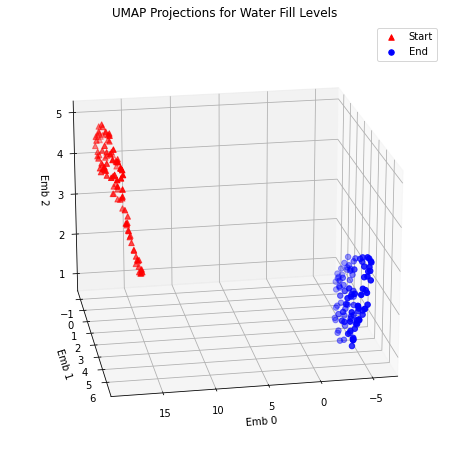

In [41]:
start_embeddings = []
middle_embeddings = []
end_embeddings = []

for ind, (key, emb) in enumerate(zip(file_dict.keys(), embedding)): #sampleid_0_level_0
#     print(key.split('_')[3])
    if key.split('_')[3] == '0':
        start_embeddings.append(embedding[ind])
    if key.split('_')[3] == '5':
        middle_embeddings.append(embedding[ind])
    if key.split('_')[3] == '11':
        end_embeddings.append(embedding[ind])
        
print(len(start_embeddings))
start_embeddings = np.stack(start_embeddings)
# middle_embeddings = np.stack(middle_embeddings)
end_embeddings = np.stack(end_embeddings)
        
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(start_embeddings[:, 0], start_embeddings[:, 1], start_embeddings[:, 2], marker='^', c='red', s=30,label='Start')
# ax.scatter(middle_embeddings[:, 0], middle_embeddings[:, 1], middle_embeddings[:, 2], marker='o', c='green', s=30,label='Middle')
ax.scatter(end_embeddings[:, 0], end_embeddings[:, 1], end_embeddings[:, 2], marker='o', c='blue', s=30,label='End')

ax.view_init(20,80)

ax.set_xlabel('Emb 0')
ax.set_ylabel('Emb 1')
ax.set_zlabel('Emb 2')

ax.set_title('UMAP Projections for Water Fill Levels')
ax.legend()